# Example MNIST classifier

## Imports + model initialization

For the 1st model initialization, you have to pass all required configuration asargument to the constructor. 

After this creation, you **do not need** to repass them all the time ! just call its constructor with `nom = model_name` and all configuration will be automatically loaded !

In [1]:
import pandas as pd

from utils import plot, plot_multiple, set_display_options
from datasets import get_dataset, prepare_dataset, test_dataset_time
from models.classification.base_classifier import BaseClassifier

set_display_options()

model_name = 'mnist_classifier'

In [ ]:
input_shape = (28, 28, 1)
model = BaseClassifier(input_shape, labels = list(range(10)), nom = model_name)

print(model)

## Model instanciation + dataset loading

In [3]:
model = BaseClassifier(nom = model_name)

model.compile()

print(model)
model.summary()

Model restoration...
Initializing submodel : classifier !
Optimizer 'classifier_optimizer' initilized successfully !
Submodel classifier compiled !
  Loss : {'reduction': 'auto', 'name': 'sparse_categorical_crossentropy', 'from_logits': False}
  Optimizer : {'name': 'Adam', 'learning_rate': 0.0010000000474974513, 'decay': 0.0, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'epsilon': 1e-07, 'amsgrad': False}
  Metrics : [{'name': 'sparse_categorical_accuracy', 'dtype': 'float32'}]
Successfully restored classifier from pretrained_models/mnist_classifier/saving/classifier.json !
Model mnist_classifier initialized successfully !
Model classifier is already compiled !

========== mnist_classifier ==========
Sub model classifier
- Inputs 	: (None, 28, 28, 1)
- Outputs 	: (None, 10)
- Number of layers 	: 15
- Number of parameters 	: 0.028 Millions
- Optimizer 	: {'name': 'Adam', 'learning_rate': 0.0010000000474974513, 'decay': 0.0, 'beta_1': 0.8999999761581421, 'beta_2': 0.99900

In [7]:
ds = get_dataset('mnist')

train, valid = ds['train'], ds['test']
print(train)
print(valid)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling mnist-train.tfrecord...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling mnist-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

## Training + history analysis

In [4]:
model.train(
    train, validation_data = valid,
    epochs = 5, batch_size = 64,
    augment_prct = 0.25
)

Training config :
HParams :
- augment_prct	: 0.25
- epochs	: 15
- batch_size	: 64
- valid_batch_size	: 32
- test_batch_size	: 1
- verbose	: 1
- train_size	: None
- valid_size	: None
- test_size	: 4
- pred_step	: -1
- shuffle_size	: 1024

Epoch 11/15
    938/Unknown - 6s 6ms/step - loss: 0.0612 - classifier_SparseCategoricalAccuracy: 0.9805
Saving at epoch 10 !

Making prediction at step 10318
938/938 [==============================] - 11s 11ms/step - loss: 0.0612 - classifier_SparseCategoricalAccuracy: 0.9805 - val_loss: 0.0295 - val_classifier_SparseCategoricalAccuracy: 0.9903
Epoch 12/15
929/938 [============================>.] - ETA: 0s - loss: 0.0610 - classifier_SparseCategoricalAccuracy: 0.9804
Saving at epoch 11 !

Making prediction at step 11256
938/938 [==============================] - 9s 9ms/step - loss: 0.0610 - classifier_SparseCategoricalAccuracy: 0.9804 - val_loss: 0.0276 - val_classifier_SparseCategoricalAccuracy: 0.9904
Epoch 13/15
934/938 [============================

===== History =====
    classifier_SparseCategoricalAccuracy      loss  val_classifier_SparseCategoricalAccuracy  \
0                               0.866050  0.417142                                    0.9737   
1                               0.951250  0.157804                                    0.9817   
2                               0.962067  0.125225                                    0.9833   
3                               0.965467  0.112064                                    0.9857   
4                               0.968950  0.101459                                    0.9865   
5                               0.972283  0.091235                                    0.9887   
6                               0.972883  0.088137                                    0.9878   
7                               0.976117  0.079962                                    0.9888   
8                               0.976467  0.076591                                    0.9895   
9                   

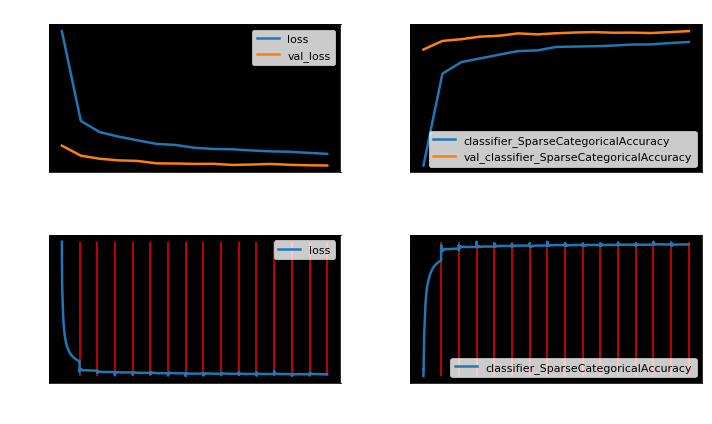

In [4]:
print(model.history)
model.plot_history()

In [5]:
print("Training config :")
print(pd.DataFrame(model.history.trainings_config))
print("\nTraining informations :")
print(pd.DataFrame(model.history.trainings_infos))


Training config :
   augment_prct  batch_size  epochs  pred_step  shuffle_size  test_batch_size  test_size  \
0          0.25          64      15         -1          1024                1          4   

  train_size  valid_batch_size valid_size  verbose  
0       None                32       None        1  

Training informations :
                   end  final_epoch  interrupted                start  start_epoch        time
0  2021-04-04 11:25:03           14        False  2021-04-04 11:21:58           -1  185.806663


## Prediction

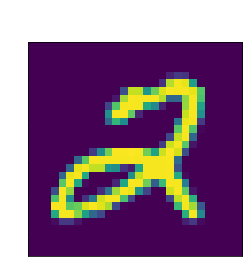

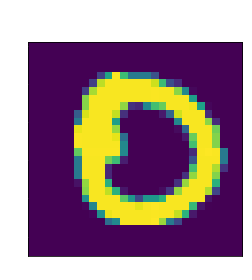

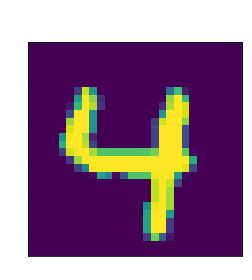

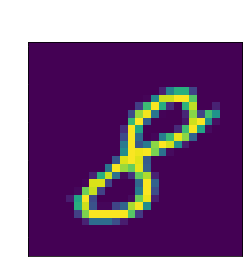

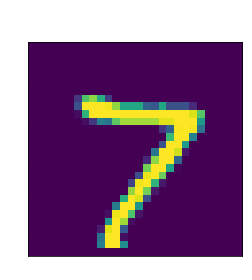

In [8]:
for i, data in enumerate(valid):
    if i >= 5: break
    image, label = data['image'], data['label']
    
    pred, score = model.predict(image)[0]
    plot(
        image, title = 'Class : {}\nPred : {} ({:.2f}%)'.format(label, pred, score * 100),
        plot_type = 'imshow'
    )

## Test dataset performance

These 3 lines allow you to debug your processing pipeline and test its performances

In [9]:
config = model.get_dataset_config(is_validation = False, batch_size = 128)

ds_train = prepare_dataset(train, ** config, debug = True)
test_dataset_time(ds_train, steps = 1000)

Original dataset : <PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>
- Dataset after mapping : <ParallelMapDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int32)>
- Dataset after batch : <BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int32)>


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 435.30it/s]


469 batchs in 1.081 sec sec (433.694 batch / sec)
Time estimated for all dataset (469 batch) : 56h 30min 2sec
Batch infos : 
Element 0 : shape : (96, 28, 28, 1) - type : <dtype: 'float32'> - min : 0.000 - max : 1.000
Element 1 : shape : (96,) - type : <dtype: 'int32'> - min : 0.000 - max : 9.000


1.0814073085784912